In [122]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import chardet
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, LSTM
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from tensorflow.keras.utils import plot_model

from tensorflow.python.keras.utils.conv_utils import conv_output_length
from keras.regularizers import l2
from tensorflow.keras.constraints import max_norm

sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

print(os.listdir("data/Amazon Reviews"))

['test.ft.txt.bz2', 'train.ft.txt.bz2']


# Read Train & Test Files

In [39]:
#### To Download Datam 

###### https://www.kaggle.com/datasets/bittlingmayer/amazonreviews/download?datasetVersionNumber=7

### Convert from raw binary strings to strings that can be parsed

In [2]:
def assign_labels_and_comments(file):
    labels = []
    comments = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        comments.append(x[10:].strip())
    return np.array(labels), comments
train_labels, train_comments = assign_labels_and_comments('data/Amazon Reviews/train.ft.txt.bz2')
test_labels, test_comments = assign_labels_and_comments('data/Amazon Reviews/test.ft.txt.bz2')

In [3]:
# train_lables = (0 if x.split(' ')[0] == '__label__' else 1 for x in train_file_line)
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_comments]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0', train_sentences[i])

In [4]:
# test_lables = (0 if x.split(' ')[0] == '__label__' else 1 for x in test_file_line)
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_comments]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d', '0', test_sentences[i])

In [5]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [6]:
train_sentences[0]

'even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_'

In [7]:
train_sentences_df = pd.DataFrame(train_sentences,columns = ['review'])
train_sentences_df.head()

,review
0,even for the non-gamer: this sound track was b...
1,best soundtrack ever to anything.: i'm reading...
2,this soundtrack is my favorite music of all ti...
3,soundtrack: i truly like this soundtrack and i...
4,pull your jaw off the floor after hearing it: ...


In [8]:
train_sentences_df['word_count'] = train_sentences_df['review'].apply(lambda x : len(x.split()))
train_sentences_df['char_count'] = train_sentences_df['review'].apply(lambda x : len(x.replace(" ","")))
train_sentences_df['word_density'] = train_sentences_df['word_count'] / (train_sentences_df['char_count'] + 1)

In [9]:
train_sentences_df.head()

,review,word_count,char_count,word_density
0,even for the non-gamer: this sound track was b...,79,339,0.232353
1,best soundtrack ever to anything.: i'm reading...,96,409,0.234146
2,this soundtrack is my favorite music of all ti...,128,622,0.205457
3,soundtrack: i truly like this soundtrack and i...,117,616,0.189627
4,pull your jaw off the floor after hearing it: ...,86,385,0.222798


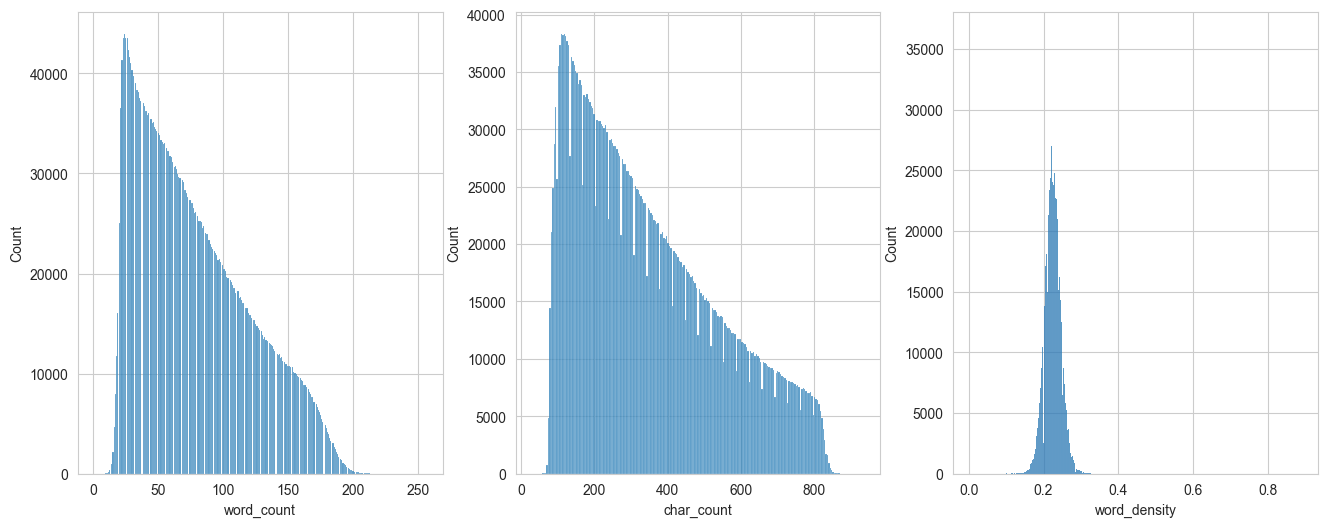

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
dp=sns.histplot (train_sentences_df['word_count'],ax=ax[0])
dp=sns.histplot (train_sentences_df['char_count'],ax=ax[1])
dp=sns.histplot (train_sentences_df['word_density'],ax=ax[2])
plt.show()

In [10]:
train_comments, val_comments, train_labels, val_labels = train_test_split(train_sentences, train_labels, 
                                                                          random_state=42, test_size=0.2)

In [13]:
gc.collect()

113

In [12]:
maximum_features = 14000


In [18]:
tokenizer = text.Tokenizer(num_words=maximum_features)
tokenizer.fit_on_texts(train_comments)
train_comments = tokenizer.texts_to_sequences(train_comments)
val_comments = tokenizer.texts_to_sequences(val_comments)
test_comments = tokenizer.texts_to_sequences(test_comments)

In [19]:
maximum_length = max(len(train_ex) for train_ex in train_comments)
train_comments_pad = sequence.pad_sequences(train_comments, maxlen=maximum_length)
val_comments_pad = sequence.pad_sequences(val_comments, maxlen=maximum_length)
test_comments_pad = sequence.pad_sequences(test_comments, maxlen=maximum_length)

In [22]:
train_comments_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## Model Implemention

In [90]:
max_features = 20000
rnn_hidden_dim = 5
word_embedding_dim = 50

In [91]:
## Let's build a RNN
model_rnn = Sequential()
#This layer takes each integer in the sequence and embeds it in a 50-dimensional vector
model_rnn.add(Embedding(max_features, word_embedding_dim))
model_rnn.add(LSTM(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=test_comments_pad.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          1000000   
                                                                 
 lstm_5 (LSTM)               (None, 5)                 1120      
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1001126 (3.82 MB)
Trainable params: 1001126 (3.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
model_rnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy'])

In [123]:
plot_model(model_rnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [96]:
weight_path="early_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

In [36]:
model_rnn.fit(
    train_comments_pad, 
    train_labels, 
    batch_size=32,
    epochs=1,
    validation_data=(val_comments_pad, val_labels), 
    callbacks=callbacks)

90000/90000 [==============================] - ETA: 0s - loss: 99835.9844 - binary_accuracy: 0.8700
Epoch 1: val_loss improved from inf to 0.20141, saving model to early_weights.hdf5
90000/90000 [==============================] - 4777s 53ms/step - loss: 99835.9844 - binary_accuracy: 0.8700 - val_loss: 0.2014 - val_binary_accuracy: 0.9225


In [38]:
rnn_preds = model_rnn.predict(test_comments_pad)

accuracy_rnn = accuracy_score(test_labels, 1 * (rnn_preds > 0.5))
f1_rnn = f1_score(test_labels, 1 * (rnn_preds > 0.5))
rocauc_rnn = roc_auc_score(test_labels, rnn_preds)

print('Accuracy score of the RNN Model: {:0.3}'.format(accuracy_rnn))
print('F1 score of the RNN Model: {:0.3}'.format(f1_rnn))
print('ROC AUC score of the RNN Model: {:0.3}'.format(rocauc_rnn))

12500/12500 [==============================] - 235s 19ms/step
Accuracy score of the RNN Model: 0.932
F1 score of the RNN Model: 0.932
ROC AUC score of the RNN Model: 0.979


In [76]:
val_acc = model_rnn.history.history["val_acc"]
val_loss = model_rnn.history.history["val_loss"]

KeyError: 'val_acc'

In [71]:
acc = model_rnn.history.history["accuracy"]
loss = model_rnn.history.history["loss"]

KeyError: 'accuracy'

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")